# Learning to Rank with RankLib and Amazon OpenSearch

이 노트북은 다음 단계를 통해 Learning to Rank(LTR) 모델을 구축하고 OpenSearch에 배포합니다:

1. Amazon Bedrock의 Claude 3.5 모델을 사용하여 데이터셋 생성
2. RankLib을 사용한 LTR 모델 학습
3. OpenSearch LTR 플러그인에 모델 배포
4. 모델 성능 평가

## 1. 필요한 라이브러리 설치 및 임포트

In [248]:
# 필요한 패키지 설치
%pip -q install boto3 opensearch-py requests pandas numpy matplotlib py4j requests-aws4auth

Note: you may need to restart the kernel to use updated packages.


In [249]:
# 라이브러리 임포트
import boto3
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
import time
import subprocess
from IPython.display import display, HTML
import random

## 2. AWS 및 OpenSearch 연결 설정

In [250]:
# AWS 설정
region = 'us-east-1'  # 사용 중인 리전으로 변경
service = 'es'

# AWS 자격 증명 설정
session = boto3.Session()
credentials = session.get_credentials()
awsauth = AWS4Auth(
    credentials.access_key,
    credentials.secret_key,
    region,
    service,
    session_token=credentials.token
)

# OpenSearch 엔드포인트 설정 (실제 엔드포인트로 변경 필요)
host = 'opensearch.example.com'

# OpenSearch 클라이언트 생성
os_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)
headers = {'Content-Type': 'application/json'}

## 3. Amazon Bedrock을 사용한 데이터셋 생성

Claude 3.5 모델을 사용하여 문서 컬렉션, 검색 쿼리, 관련성 판단 데이터를 생성합니다.

In [251]:
# Bedrock 클라이언트 설정
bedrock_runtime = boto3.client('bedrock-runtime', region_name=region)


def invoke_claude(prompt, model_id="anthropic.claude-3-5-sonnet-20240620-v1:0", max_tokens=4096):
    """Claude 3.5 모델을 호출하여 응답을 받습니다."""
    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": max_tokens,
        "messages": [{"role": "user", "content": prompt}]
    }

    response = bedrock_runtime.invoke_model(
        modelId=model_id,
        body=json.dumps(request_body)
    )

    response_body = json.loads(response.get('body').read())
    return response_body['content'][0]['text']

### 3.1 문서 컬렉션 생성

In [252]:
# 문서 컬렉션 생성을 위한 프롬프트
import re
import time
model_id = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"

# 생성할 문서 수 설정
num_documents = 20

# 문서를 한 번에 10개씩 생성하는 프롬프트
documents = []
for batch in range(0, num_documents, 10):
    end_idx = min(batch + 10, num_documents)
    batch_size = end_idx - batch

    print(
        f"배치 {batch//10 + 1}/{(num_documents + 9)//10} 생성 시작 (문서 {batch+1}-{end_idx})")

    # 한 번에 10개의 문서를 생성하는 프롬프트
    batch_prompt = f"""
    다음 주제에 관한 {batch_size}개의 문서를 생성해주세요: "인공지능과 기계학습"
    
    각 문서는 다음 형식의 JSON 객체여야 합니다:
    {{
      "id": "doc[번호]",
      "title": "문서 제목",
      "content": "문서 내용 (300-400자)"
    }}
    
    문서들은 인공지능과 기계학습의 다양한 측면(기초 개념, 응용, 역사, 최신 트렌드 등)을 다루어야 합니다.
    전체 응답은 유효한 JSON 배열 형식이어야 합니다.
    
    다음 ID를 사용하세요: {', '.join([f'"doc{i+1}"' for i in range(batch, end_idx)])}
    """
    # Claude 호출하여 문서 배치 생성
    max_retries = 3
    retry_count = 0
    while retry_count < max_retries:
        try:
            batch_json = invoke_claude(batch_prompt, model_id, max_tokens=8192)
            break
        except Exception as e:
            retry_count += 1
            print(f"오류 발생: {str(e)}")
            if retry_count < max_retries:
                print(f"30초 후 재시도합니다. (시도 {retry_count}/{max_retries})")
                time.sleep(30)
            else:
                print("최대 재시도 횟수를 초과했습니다.")
                raise

    # JSON 문자열에서 실제 JSON 배열 부분만 추출
    json_pattern = r'\[.*\]'
    json_match = re.search(json_pattern, batch_json, re.DOTALL)
    if json_match:
        batch_json = json_match.group(0)

    try:
        # JSON 파싱
        batch_documents = json.loads(batch_json)

        # ID 확인 및 수정
        for i, doc in enumerate(batch_documents):
            doc_id = f"doc{batch+i+1}"
            doc["id"] = doc_id
            documents.append(doc)
            print(f"문서 {batch+i+1}/{num_documents} 처리 완료")
    except json.JSONDecodeError:
        print(f"JSON 파싱 오류 발생. 원본 응답: {batch_json}")

    # 배치 완료 후 휴식
    if batch + 10 < num_documents:
        print(f"배치 {batch//10 + 1} 완료. 다음 배치 전 60초 대기...")
        time.sleep(40)

# 데이터 저장
os.makedirs('data', exist_ok=True)
with open('data/documents.json', 'w', encoding='utf-8') as f:
    json.dump(documents, f, ensure_ascii=False, indent=2)

# 생성된 문서 확인
print(f"생성된 문서 수: {len(documents)}")
print("첫 번째 문서 샘플:")
print(json.dumps(documents[0], ensure_ascii=False, indent=2))

배치 1/2 생성 시작 (문서 1-10)
문서 1/20 처리 완료
문서 2/20 처리 완료
문서 3/20 처리 완료
문서 4/20 처리 완료
문서 5/20 처리 완료
문서 6/20 처리 완료
문서 7/20 처리 완료
문서 8/20 처리 완료
문서 9/20 처리 완료
문서 10/20 처리 완료
배치 1 완료. 다음 배치 전 60초 대기...
배치 2/2 생성 시작 (문서 11-20)
오류 발생: Read timeout on endpoint URL: "https://bedrock-runtime.us-east-1.amazonaws.com/model/us.anthropic.claude-3-5-sonnet-20241022-v2%3A0/invoke"
30초 후 재시도합니다. (시도 1/3)
오류 발생: Read timeout on endpoint URL: "https://bedrock-runtime.us-east-1.amazonaws.com/model/us.anthropic.claude-3-5-sonnet-20241022-v2%3A0/invoke"
30초 후 재시도합니다. (시도 2/3)
문서 11/20 처리 완료
문서 12/20 처리 완료
문서 13/20 처리 완료
문서 14/20 처리 완료
문서 15/20 처리 완료
문서 16/20 처리 완료
문서 17/20 처리 완료
문서 18/20 처리 완료
문서 19/20 처리 완료
문서 20/20 처리 완료
생성된 문서 수: 20
첫 번째 문서 샘플:
{
  "id": "doc1",
  "title": "인공지능의 기초 개념과 정의",
  "content": "인공지능(AI)은 인간의 학습능력과 추론능력, 지각능력, 자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술입니다. 좁은 의미의 AI는 특정 작업을 수행하는 약한 AI를, 넓은 의미의 AI는 인간처럼 사고하고 행동하는 강한 AI를 의미합니다. 현대의 AI는 주로 특정 분야에서 뛰어난 성능을 보이는 약한 AI의 형태로 발전하고 있으며, 데이터 처리와 패턴 인식 능력을

### 3.2 검색 쿼리 생성

In [253]:
model_id = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"
# 검색 쿼리 생성을 위한 변수 설정
num_queries = 100
queries = []

# 10개씩 배치로 쿼리 생성
for batch in range(0, num_queries, 10):
    # 현재 배치에서 생성할 쿼리 수 계산
    batch_size = min(10, num_queries - batch)
    end_idx = batch + batch_size

    # 문서 컬렉션에서 랜덤하게 샘플링 (토큰 제한 방지)
    sample_size = min(10, len(documents))  # 최대 10개 문서만 사용
    random_docs = random.sample(documents, sample_size)

    batch_prompt = f"""
    앞서 생성한 문서 컬렉션에 대해 사용자가 검색할 만한 쿼리 {batch_size}개를 생성해주세요.
    문서들은 인공지능과 기계학습의 다양한 측면(기초 개념, 응용, 역사, 최신 트렌드 등)을 다루고 있습니다.
    각 쿼리는 다음 형식의 JSON 객체여야 합니다:
    {{{{
        "id": "q[번호]",
        "text": "검색 쿼리 내용"
    }}}}

    쿼리는 다양한 난이도와 구체성을 가져야 합니다.
    쿼리는 단순 키워드일수도 있고 문장일 수도 있습니다.
    전체 응답은 유효한 JSON 배열 형식이어야 합니다.
    
    다음 ID를 사용하세요: {', '.join([f'"q{i+1}"' for i in range(batch, end_idx)])}

    다음은 문서 컬렉션의 일부 샘플입니다:
    ```
    {json.dumps(random_docs, ensure_ascii=False)}
    ```
    """

    # Claude 호출하여 쿼리 배치 생성
    max_retries = 3
    retry_count = 0
    while retry_count < max_retries:
        try:
            batch_json = invoke_claude(batch_prompt, model_id, max_tokens=8192)
            break
        except Exception as e:
            retry_count += 1
            print(f"오류 발생: {str(e)}")
            if retry_count < max_retries:
                print(f"30초 후 재시도합니다. (시도 {retry_count}/{max_retries})")
                time.sleep(30)
            else:
                print("최대 재시도 횟수를 초과했습니다.")
                raise

    # JSON 문자열에서 실제 JSON 배열 부분만 추출
    json_pattern = r'\[.*\]'
    json_match = re.search(json_pattern, batch_json, re.DOTALL)
    if json_match:
        batch_json = json_match.group(0)

    try:
        # JSON 파싱
        batch_queries = json.loads(batch_json)

        # ID 확인 및 수정
        for i, query in enumerate(batch_queries):
            query_id = f"q{batch+i+1}"
            query["id"] = query_id
            queries.append(query)
            print(f"쿼리 {batch+i+1}/{num_queries} 생성 완료")
    except json.JSONDecodeError:
        print(f"JSON 파싱 오류 발생. 원본 응답: {batch_json}")

    # 배치 완료 후 휴식
    if batch + 10 < num_queries:
        print(f"배치 {batch//10 + 1} 완료. 다음 배치 전 30초 대기...")
        time.sleep(40)

# 데이터 저장
with open('data/queries.json', 'w', encoding='utf-8') as f:
    json.dump(queries, f, ensure_ascii=False, indent=2)

# 생성된 쿼리 확인
print(f"생성된 쿼리 수: {len(queries)}")
print("쿼리 샘플:")
for q in queries[:3]:
    print(f"- {q['text']}")

쿼리 1/100 생성 완료
쿼리 2/100 생성 완료
쿼리 3/100 생성 완료
쿼리 4/100 생성 완료
쿼리 5/100 생성 완료
쿼리 6/100 생성 완료
쿼리 7/100 생성 완료
쿼리 8/100 생성 완료
쿼리 9/100 생성 완료
쿼리 10/100 생성 완료
배치 1 완료. 다음 배치 전 30초 대기...
쿼리 11/100 생성 완료
쿼리 12/100 생성 완료
쿼리 13/100 생성 완료
쿼리 14/100 생성 완료
쿼리 15/100 생성 완료
쿼리 16/100 생성 완료
쿼리 17/100 생성 완료
쿼리 18/100 생성 완료
쿼리 19/100 생성 완료
쿼리 20/100 생성 완료
배치 2 완료. 다음 배치 전 30초 대기...
쿼리 21/100 생성 완료
쿼리 22/100 생성 완료
쿼리 23/100 생성 완료
쿼리 24/100 생성 완료
쿼리 25/100 생성 완료
쿼리 26/100 생성 완료
쿼리 27/100 생성 완료
쿼리 28/100 생성 완료
쿼리 29/100 생성 완료
쿼리 30/100 생성 완료
배치 3 완료. 다음 배치 전 30초 대기...
쿼리 31/100 생성 완료
쿼리 32/100 생성 완료
쿼리 33/100 생성 완료
쿼리 34/100 생성 완료
쿼리 35/100 생성 완료
쿼리 36/100 생성 완료
쿼리 37/100 생성 완료
쿼리 38/100 생성 완료
쿼리 39/100 생성 완료
쿼리 40/100 생성 완료
배치 4 완료. 다음 배치 전 30초 대기...
쿼리 41/100 생성 완료
쿼리 42/100 생성 완료
쿼리 43/100 생성 완료
쿼리 44/100 생성 완료
쿼리 45/100 생성 완료
쿼리 46/100 생성 완료
쿼리 47/100 생성 완료
쿼리 48/100 생성 완료
쿼리 49/100 생성 완료
쿼리 50/100 생성 완료
배치 5 완료. 다음 배치 전 30초 대기...
쿼리 51/100 생성 완료
쿼리 52/100 생성 완료
쿼리 53/100 생성 완료
쿼리 54/100 생성 완료
쿼리 55/100 

## 4. OpenSearch 인덱스 및 문서 설정

OpenSearch의 LTR에 사용되는 인덱스를 생성하는 코드입니다. 아래의 코드를 통해 인덱스를 생성하고 4.1 코드를 통해서 판단 데이터를 생성합니다.
아래의 코드를 수행하기전 Amazon OpenSearch Service에서 Nori Plugin을 설치해주세요. 관련한 자세한 내용은 [Amazon OpenSearch Service, 한국어 분석을 위한 ‘노리(Nori)’ 플러그인 활용](https://aws.amazon.com/ko/blogs/tech/amazon-opensearch-service-korean-nori-plugin-for-analysis/) 에서 확인할 수 있습니다.

In [254]:
# 인덱스 이름 설정
index_name = 'opensearch-ltr-sample'

# 인덱스 매핑 정의
index_mapping = {
    "settings": {
        "analysis": {
            "tokenizer": {
                "nori_tokenizer_dict": {
                    "type": "nori_tokenizer",
                    "decompound_mode": "mixed",
                    "discard_punctuation": "true",
                }
            },
            "analyzer": {
                "custom_analyzer": {
                    "type": "custom",
                    "tokenizer": "nori_tokenizer_dict",
                    "filter": [
                        "lowercase",
                        "nori_part_of_speech"
                    ],
                    "char_filter": [
                        "html_strip"
                    ]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "title": {
                "type": "text", "fielddata": True,
                "analyzer": "custom_analyzer"
            },
            "content": {
                "type": "text", "fielddata": True,
                "analyzer": "custom_analyzer"
            }
        }
    }
}

# 인덱스가 존재하는 경우 삭제
delete_response = requests.delete(
    f"https://{host}/{index_name}",
    auth=awsauth,
    headers=headers
)
if delete_response.status_code == 200:
    print(f"기존 인덱스 '{index_name}' 삭제됨")

# 인덱스 생성
create_response = requests.put(
    f"https://{host}/{index_name}",
    auth=awsauth,
    headers=headers,
    json=index_mapping
)
print(create_response.text)
print(f"인덱스 '{index_name}' 생성됨")

# 문서 인덱싱
for doc in documents:
    index_response = requests.put(
        f"https://{host}/{index_name}/_doc/{doc['id']}",
        auth=awsauth,
        headers=headers,
        json={
            'title': doc['title'],
            'content': doc['content']
        }
    )

# 인덱스 새로고침
refresh_response = requests.post(
    f"https://{host}/{index_name}/_refresh",
    auth=awsauth,
    headers=headers
)
print(f"{len(documents)}개 문서가 인덱싱됨")

기존 인덱스 'opensearch-ltr-sample' 삭제됨
{"acknowledged":true,"shards_acknowledged":true,"index":"opensearch-ltr-sample"}
인덱스 'opensearch-ltr-sample' 생성됨
20개 문서가 인덱싱됨


### 4.1 판단 데이터 생성

LTR의 feature를 생성하기 위해서는 판단 데이터가 필요합니다. 아래의 코드를 통해서 판단 데이터를 생성합니다.
판단 데이터를 생성하고 feature_set을 생성하기전 OpenSearch에 연결하기 위해 사용한 AWS credentials의 Role을 OpenSearch의 Backend Role로 등록해주세요.
> OpenSearch 대시보드 > Security > Roles > all_access 에서 Maaped users의 Backend role에 Notebooks에서 사용하는 IAM arn을 등록해주세요

In [269]:
import random
model_id = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"

# 각 쿼리에 대해 OpenSearch 검색 수행 및 관련성 평가
all_judgments = []

for query in queries:
    query_id = query['id']  # 'q1' 형식
    query_text = query['text']

    # OpenSearch에서 검색 수행
    search_query = {
        "query": {
            "multi_match": {
                "query": query_text,
                "fields": ["title", "content"]
            }
        },
        "size": 30
    }

    # 검색 실행 및 최대 3번까지 재시도
    max_search_retries = 3
    search_retry_count = 0
    search_success = False

    while not search_success and search_retry_count < max_search_retries:
        try:
            search_response = os_client.search(
                index=index_name, body=search_query)
            search_success = True
        except Exception as e:
            search_retry_count += 1
            print(f"검색 오류 발생: {str(e)}")
            if search_retry_count < max_search_retries:
                print(
                    f"1초 후 재시도합니다. (시도 {search_retry_count}/{max_search_retries})")
                time.sleep(1)
            else:
                print("검색 최대 재시도 횟수를 초과했습니다.")
                raise
    top_docs = search_response['hits']['hits']

    # 상위 10개 문서에 대한 관련성 평가 프롬프트 생성
    doc_list = [{
        "id": hit['_id'],
        "title": hit['_source']['title'],
        "content": hit['_source']['content']
    } for hit in top_docs]

    judgments_prompt = """
    다음 검색 쿼리와 검색 결과 문서에 대해 각 문서의 관련성을 평가해주세요.
    목표는 제공된 문서워 쿼리를 기반으로 0~4점 사이의 점수를 할당하는것 입니다.
    각 평가는 다음 형식의 JSON 객체여야 합니다:
    {{
        "query_id": "{}",
        "doc_id": "doc1",
        "relevance": 4
    }}

    관련성 점수는 0-4 범위로 평가합니다:
    - 0: 문서나 항목이 검색어와 관련이 없습니다. 검색어에 대한 유용한 정보를 제공하지 않습니다.
    - 1: 문서나 항목이 검색어와 조금 관련이 있지만 유용하지 않습니다. 검색어와 관련된 키워드를 포함할 수 있지만, 검색어의 의도를 의미 있게 다루지 않습니다.
    - 2: 문서나 항목이 검색어와 관련이 있으며 유용할 수 있습니다. 부분적으로 검색어와 일치하지만 깊이나 포괄성이 부족한 정보를 포함합니다.
    - 3: 문서나 항목이 검색어와 관련성이 높고 유용합니다. 검색어의 의도를 직접적으로 다루는 실질적인 정보를 제공합니다.
    - 4: 문서나 항목이 검색어와 관련성이 매우 높고 유용합니다. 검색어의 의도를 완벽하게 충족하는 포괄적인 정보를 제공합니다.

    검색 쿼리: {}
    
    검색 결과 문서:
    {}
    
    전체 응답은 유효한 JSON 배열 형식이어야 합니다.
    """.format(query_id, query_text, json.dumps(doc_list, ensure_ascii=False))

    # Claude 호출하여 관련성 판단 생성
    max_retries = 3
    retry_count = 0
    while retry_count < max_retries:
        try:
            judgments_json = invoke_claude(
                judgments_prompt, model_id, max_tokens=8192)
            break
        except Exception as e:
            retry_count += 1
            print(f"오류 발생: {str(e)}")
            if retry_count < max_retries:
                print(f"30초 후 재시도합니다. (시도 {retry_count}/{max_retries})")
                time.sleep(30)
            else:
                print("최대 재시도 횟수를 초과했습니다.")
                raise

    # JSON 문자열에서 실제 JSON 부분만 추출
    json_match = re.search(json_pattern, judgments_json, re.DOTALL)
    if json_match:
        query_judgments = json.loads(json_match.group(0))
        # 각 판단에 쿼리 ID 설정
        for judgment in query_judgments:
            judgment['query_id'] = query_id
        all_judgments.extend(query_judgments)  # extend를 사용하여 개별 판단을 추가

    print(f"쿼리 {query_id}에 대한 관련성 판단 생성 완료")
    time.sleep(30)

# 데이터 저장
with open('data/judgments.json', 'w', encoding='utf-8') as f:
    json.dump(all_judgments, f, ensure_ascii=False, indent=2)

# 테스트 쿼리 ID 선택 (전체 쿼리의 30%를 테스트용으로 사용)
all_query_ids = [q['id'][1:] for q in queries]  # 'q1' -> '1'
test_query_ids = random.sample(all_query_ids, int(len(all_query_ids) * 0.3))

print(f"생성된 관련성 판단 수: {len(all_judgments)}")
print(f"테스트 쿼리 ID: {test_query_ids}")

쿼리 q1에 대한 관련성 판단 생성 완료
쿼리 q2에 대한 관련성 판단 생성 완료
쿼리 q3에 대한 관련성 판단 생성 완료
쿼리 q4에 대한 관련성 판단 생성 완료
쿼리 q5에 대한 관련성 판단 생성 완료
쿼리 q6에 대한 관련성 판단 생성 완료
쿼리 q7에 대한 관련성 판단 생성 완료
쿼리 q8에 대한 관련성 판단 생성 완료
쿼리 q9에 대한 관련성 판단 생성 완료
쿼리 q10에 대한 관련성 판단 생성 완료
쿼리 q11에 대한 관련성 판단 생성 완료
쿼리 q12에 대한 관련성 판단 생성 완료
쿼리 q13에 대한 관련성 판단 생성 완료
쿼리 q14에 대한 관련성 판단 생성 완료
쿼리 q15에 대한 관련성 판단 생성 완료
쿼리 q16에 대한 관련성 판단 생성 완료
쿼리 q17에 대한 관련성 판단 생성 완료
쿼리 q18에 대한 관련성 판단 생성 완료
쿼리 q19에 대한 관련성 판단 생성 완료
쿼리 q20에 대한 관련성 판단 생성 완료
쿼리 q21에 대한 관련성 판단 생성 완료
쿼리 q22에 대한 관련성 판단 생성 완료
쿼리 q23에 대한 관련성 판단 생성 완료
쿼리 q24에 대한 관련성 판단 생성 완료
쿼리 q25에 대한 관련성 판단 생성 완료
쿼리 q26에 대한 관련성 판단 생성 완료
쿼리 q27에 대한 관련성 판단 생성 완료
쿼리 q28에 대한 관련성 판단 생성 완료
쿼리 q29에 대한 관련성 판단 생성 완료
쿼리 q30에 대한 관련성 판단 생성 완료
쿼리 q31에 대한 관련성 판단 생성 완료
쿼리 q32에 대한 관련성 판단 생성 완료
쿼리 q33에 대한 관련성 판단 생성 완료
쿼리 q34에 대한 관련성 판단 생성 완료
쿼리 q35에 대한 관련성 판단 생성 완료
쿼리 q36에 대한 관련성 판단 생성 완료
쿼리 q37에 대한 관련성 판단 생성 완료
쿼리 q38에 대한 관련성 판단 생성 완료
쿼리 q39에 대한 관련성 판단 생성 완료
쿼리 q40에 대한 관련성 판단 생성 완료
쿼리 q41에 대한 관련성 판단 생성 완료
쿼리 q42에 대한 관련성 판단 생성 완료
쿼

## 5. OpenSearch LTR 플러그인 설정

In [275]:
# LTR 저장소 초기화
ltr_store_endpoint = f"https://{host}/_ltr"
featureset_name = "ltr_features"
# LTR 저장소 생성
init_response = requests.put(
    f"{ltr_store_endpoint}",
    auth=awsauth,
    headers=headers
)
print(f"LTR 저장소 초기화 응답: {init_response.status_code}")

# 기존 특성 집합 삭제
delete_response = requests.delete(
    f"{ltr_store_endpoint}/_featureset/ltr_features",
    auth=awsauth,
    headers=headers
)
print(f"기존 특성 집합 삭제 응답: {delete_response.status_code}")

# 특성 집합(featureset) 정의
featureset = {
    "featureset": {
        "name": featureset_name,
        "features": [
            {
                "name": "bm25_score",
                "params": ["keywords"],
                "template": {
                    "match": {
                        "content": "{{keywords}}"
                    }
                }
            },
            {
                "name": "title_match",
                "params": ["keywords"],
                "template": {
                    "match": {
                        "title": "{{keywords}}"
                    }
                }
            },
            {
                "name": "content_match",
                "params": ["keywords"],
                "template": {
                    "match": {
                        "content": "{{keywords}}"
                    }
                }
            },
            {
                "name": "title_bm25",
                "params": ["keywords"],
                "template": {
                    "match": {
                        "title": {
                            "query": "{{keywords}}",
                            "boost": 2.0
                        }
                    }
                }
            },
            {
                "name": "content_bm25",
                "params": ["keywords"],
                "template": {
                    "match": {
                        "content": {
                            "query": "{{keywords}}",
                            "boost": 1.0
                        }
                    }
                }
            },
            {
                "name": "title_length",
                "params": [],
                "template_language": "mustache",
                "template": {
                    "function_score": {
                        "functions": [
                            {
                                "script_score": {
                                    "script": {
                                        "source": "doc['title'].value.length()"
                                    }
                                }
                            }
                        ],
                        "query": {
                            "match_all": {}
                        }
                    }
                }
            },
            {
                "name": "content_length",
                "params": [],
                "template_language": "mustache",
                "template": {
                    "function_score": {
                        "functions": [
                            {
                                "script_score": {
                                    "script": {
                                        "source": "doc['content'].value.length()"
                                    }
                                }
                            }
                        ],
                        "query": {
                            "match_all": {}
                        }
                    }
                }
            }
        ]
    }
}

# 특성 집합 생성
featureset_response = requests.post(
    f"{ltr_store_endpoint}/_featureset/ltr_features",
    auth=awsauth,
    headers=headers,
    json=featureset
)
print(f"특성 집합 생성 응답: {featureset_response.status_code}")

# 특성 집합 상태 확인
featureset_status = requests.get(
    f"{ltr_store_endpoint}/_featureset/ltr_features",
    auth=awsauth,
    headers=headers
)
print(f"특성 집합 상태: {featureset_status.status_code}")
if featureset_status.status_code == 200:
    print("특성 집합 내용:")
    print(json.dumps(featureset_status.json(), indent=2))

LTR 저장소 초기화 응답: 400
기존 특성 집합 삭제 응답: 200
특성 집합 생성 응답: 201
특성 집합 상태: 200
특성 집합 내용:
{
  "_index": ".ltrstore",
  "_id": "featureset-ltr_features",
  "_version": 38,
  "_seq_no": 103,
  "_primary_term": 1,
  "found": true,
  "_source": {
    "name": "ltr_features",
    "type": "featureset",
    "featureset": {
      "name": "ltr_features",
      "features": [
        {
          "name": "bm25_score",
          "params": [
            "keywords"
          ],
          "template_language": "mustache",
          "template": {
            "match": {
              "content": "{{keywords}}"
            }
          }
        },
        {
          "name": "title_match",
          "params": [
            "keywords"
          ],
          "template_language": "mustache",
          "template": {
            "match": {
              "title": "{{keywords}}"
            }
          }
        },
        {
          "name": "content_match",
          "params": [
            "keywords"
          ],
      

## 6. 특성 로그 생성 및 RankLib 학습 데이터 준비

In [276]:
# 특성 로그 생성 함수
def log_features(query_text, doc_ids, query_id):
    """특정 쿼리와 문서 ID 목록에 대한 특성 로그를 생성합니다."""
    sltr_query = {
        "query": {
            "bool": {
                "filter": [
                    {
                        "ids": {
                            "values": doc_ids
                        }
                    },
                    {
                        "sltr": {
                            "_name": "logged_featureset",
                            "featureset": featureset_name,
                            "params": {
                                "keywords": query_text,
                                "query_id": query_id  # 쿼리 ID 추가
                            }
                        }
                    }
                ]
            }
        },
        "ext": {
            "ltr_log": {
                "log_specs": {
                    "name": "log_entry",
                    "named_query": "logged_featureset"
                }
            }
        },
        "size": len(doc_ids)
    }

    response = os_client.search(index=index_name, body=sltr_query)
    return response


# RankLib 형식의 학습 데이터 생성
ranklib_data = []

# 각 쿼리에 대해 특성 로그 생성
for query in queries:
    query_id = query['id']  # 'q1' 형식
    query_text = query['text']

    # 이 쿼리에 대한 관련성 판단 가져오기
    query_judgments = [j for j in all_judgments if j['query_id'] == query_id]

    if not query_judgments:
        print(f"쿼리 {query_id}에 대한 관련성 판단이 없습니다. 건너뜁니다.")
        continue

    # 관련성 판단이 있는 문서 ID만 추출
    judged_doc_ids = [j['doc_id'] for j in query_judgments]

    # 문서 ID와 관련성 점수 매핑
    relevance_map = {j['doc_id']: j['relevance'] for j in query_judgments}

    # 특성 로그 생성
    max_retries = 3
    retry_count = 0
    while retry_count < max_retries:
        try:
            log_response = log_features(
                query_text, judged_doc_ids, query_id)  # 관련성 판단이 있는 문서만 전달
            break
        except Exception as e:
            retry_count += 1
            if retry_count >= max_retries:
                raise
            print(f"오류 발생: {e}. {retry_count}번째 시도 실패. 1초 후 다시 시도합니다.")
            time.sleep(1)

    # 로그에서 특성 추출
    for hit in log_response['hits']['hits']:
        doc_id = hit['_id']
        relevance = relevance_map.get(doc_id, 0)

        # 특성 값 추출
        features = hit['fields']['_ltrlog'][0]['log_entry']
        feature_values = []

        for i, feature in enumerate(features):
            feature_name = feature['name']
            feature_value = feature.get('value', 0)
            feature_values.append(f"{i+1}:{feature_value}")

        # RankLib 형식으로 변환 (qid:query_id 형식)
        ranklib_line = f"{relevance} qid:{query_id[1:]} {' '.join(feature_values)} # {doc_id}"
        ranklib_data.append(ranklib_line)

    print(f"쿼리 {query_id}에 대한 특성 로그 생성 완료 (문서 수: {len(judged_doc_ids)})")

# RankLib 데이터 파일 저장
with open('data/ranklib_train.txt', 'w') as f:
    f.write('\n'.join(ranklib_data))

print(f"RankLib 학습 데이터 생성 완료: {len(ranklib_data)}개 항목")

쿼리 q1에 대한 특성 로그 생성 완료 (문서 수: 6)
쿼리 q2에 대한 특성 로그 생성 완료 (문서 수: 6)
쿼리 q3에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q4에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q5에 대한 특성 로그 생성 완료 (문서 수: 18)
쿼리 q6에 대한 특성 로그 생성 완료 (문서 수: 17)
쿼리 q7에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q8에 대한 특성 로그 생성 완료 (문서 수: 14)
쿼리 q9에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q10에 대한 특성 로그 생성 완료 (문서 수: 17)
쿼리 q11에 대한 특성 로그 생성 완료 (문서 수: 7)
쿼리 q12에 대한 특성 로그 생성 완료 (문서 수: 15)
쿼리 q13에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q14에 대한 특성 로그 생성 완료 (문서 수: 12)
쿼리 q15에 대한 특성 로그 생성 완료 (문서 수: 14)
쿼리 q16에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q17에 대한 특성 로그 생성 완료 (문서 수: 20)
쿼리 q18에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q19에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q20에 대한 특성 로그 생성 완료 (문서 수: 8)
쿼리 q21에 대한 특성 로그 생성 완료 (문서 수: 6)
쿼리 q22에 대한 특성 로그 생성 완료 (문서 수: 6)
쿼리 q23에 대한 특성 로그 생성 완료 (문서 수: 19)
쿼리 q24에 대한 특성 로그 생성 완료 (문서 수: 9)
쿼리 q25에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q26에 대한 특성 로그 생성 완료 (문서 수: 11)
쿼리 q27에 대한 특성 로그 생성 완료 (문서 수: 18)
쿼리 q28에 대한 특성 로그 생성 완료 (문서 수: 16)
쿼리 q29에 대한 특성 로그 생성 완료 (문서 수: 3)
쿼리 q30에 대한 특성 로그 생성 완료 (문서 수: 1

## 7. RankLib 학습 

In [278]:
# RankLib 다운로드 및 모델 학습
import os
import subprocess

# RankLib JAR 파일 다운로드 (없는 경우)
ranklib_dir = 'lib'
os.makedirs(ranklib_dir, exist_ok=True)
ranklib_jar = os.path.join(ranklib_dir, 'RankLib-2.18.jar')

if not os.path.exists(ranklib_jar):
    print("RankLib JAR 파일 다운로드 중...")
    download_url = "https://sourceforge.net/projects/lemur/files/lemur/RankLib-2.18/RankLib-2.18.jar/download"
    subprocess.run(['curl', '-L', download_url, '-o', ranklib_jar], check=True)
    print("다운로드 완료")

# 학습 데이터 경로
train_data = 'data/ranklib_train.txt'
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_output = os.path.join(model_dir, 'lambdamart_model.txt')

# LambdaMART 모델 학습
# 파라미터 설명:
# -ranker 6: LambdaMART 알고리즘 사용
# -metric2t NDCG@10: 최적화할 메트릭
# -tree 1000: 트리 개수
# -leaf 10: 리프 노드 개수
# -shrinkage 0.1: 학습률
print("LambdaMART 모델 학습 시작...")
training_command = [
    'java', '-jar', ranklib_jar,
    '-train', train_data,
    '-ranker', '6',
    '-metric2t', 'NDCG@10',
    '-save', model_output,
    '-tree', '1000',
    '-leaf', '10',
    '-shrinkage', '0.1'
]

try:
    result = subprocess.run(
        training_command,
        check=True,
        capture_output=True,
        text=True
    )
    print("모델 학습 완료")
    print("모델 저장 위치:", model_output)

    # 학습 로그 출력
    print("\n학습 로그:")
    print(result.stdout)

except subprocess.CalledProcessError as e:
    print("모델 학습 중 오류 발생:")
    print(e.output)

LambdaMART 모델 학습 시작...
모델 학습 완료
모델 저장 위치: models/lambdamart_model.txt

학습 로그:

Discard orig. features
Training data:	data/ranklib_train.txt
Feature vector representation: Dense.
Ranking method:	LambdaMART
Feature description file:	Unspecified. All features will be used.
Train metric:	NDCG@10
Test metric:	NDCG@10
Feature normalization: No
Model file: models/lambdamart_model.txt

[+] LambdaMART's Parameters:
No. of trees: 1000
No. of leaves: 10
No. of threshold candidates: 256
Min leaf support: 1
Learning rate: 0.1
Stop early: 100 rounds without performance gain on validation data


Reading feature file [data/ranklib_train.txt]: 0... 
Reading feature file [data/ranklib_train.txt]... [Done.]            
(100 ranked lists, 1423 entries read)
Initializing... [Done]
---------------------------------
Training starts...
---------------------------------
#iter   | NDCG@10-T | NDCG@10-V | 
---------------------------------
1       | 0.8886    | 
2       | 0.9045    | 
3       | 0.9109    | 
4   

## 8. 학습된 모델을 OpenSearch에 배포

In [279]:
# 학습된 모델 파일 읽기
with open('models/lambdamart_model.txt', 'r') as f:
    model_content = f.read()

model_name = "ltr_model"

# 기존 모델이 있는지 확인
check_model_response = requests.get(
    f"{ltr_store_endpoint}/_model/{model_name}",
    auth=awsauth,
    headers=headers
)

# 모델이 있으면 삭제
if check_model_response.status_code == 200:
    print(f"기존 모델 '{model_name}'이 존재합니다. 삭제합니다...")
    delete_response = requests.delete(
        f"{ltr_store_endpoint}/_model/{model_name}",
        auth=awsauth,
        headers=headers
    )
    print(f"모델 삭제 응답: {delete_response.status_code}")
    if delete_response.status_code != 200:
        print(delete_response.text)

# 모델 배포
model_payload = {
    "model": {
        "name": model_name,
        "model": {
            "type": "model/ranklib",
            "definition": model_content
        }
    }
}

model_response = requests.post(
    f"{ltr_store_endpoint}/_featureset/{featureset_name}/_createmodel",
    auth=awsauth,
    headers=headers,
    json=model_payload
)

print(f"모델 배포 응답: {model_response.status_code}")
print(model_response.text)
if model_response.status_code != 201:
    print(model_response.text)

기존 모델 'ltr_model'이 존재합니다. 삭제합니다...
모델 삭제 응답: 200
모델 배포 응답: 201
{"_index":".ltrstore","_id":"model-ltr_model","_version":35,"result":"created","forced_refresh":true,"_shards":{"total":3,"successful":3,"failed":0},"_seq_no":105,"_primary_term":1}


## 9. 모델 테스트 및 평가

In [290]:
# LTR 모델을 사용한 검색 함수
def search_with_ltr(query_text, size=10):
    """LTR 모델을 사용하여 검색을 수행합니다."""
    ltr_query = {
        "query": {
            "multi_match": {
                "query": query_text,
                "fields": ["title", "content"]
            }
        },
        "rescore": {
            "window_size": 100,
            "query": {
                "rescore_query": {
                    "sltr": {
                        "params": {
                            "keywords": query_text
                        },
                        "model": model_name
                    }
                }
            }
        },
        "size": size
    }

    response = os_client.search(index=index_name, body=ltr_query)
    return response

# 기본 BM25 검색 함수


def search_with_bm25(query_text, size=10):
    """기본 BM25 알고리즘을 사용하여 검색을 수행합니다."""
    bm25_query = {
        "query": {
            "multi_match": {
                "query": query_text,
                "fields": ["title", "content"]
            }
        },
        "size": size
    }

    response = os_client.search(index=index_name, body=bm25_query)
    return response


# 테스트 쿼리 선택
test_query = queries[4]['text']

# BM25와 LTR 결과 비교
bm25_results = search_with_bm25(test_query)
ltr_results = search_with_ltr(test_query)

print(f"테스트 쿼리: '{test_query}'\n")

print("BM25 결과:")
for i, hit in enumerate(bm25_results['hits']['hits']):
    print(f"{i+1}. {hit['_source']['title']} (점수: {hit['_score']:.4f})")

print("\nLTR 결과:")
for i, hit in enumerate(ltr_results['hits']['hits']):
    print(f"{i+1}. {hit['_source']['title']} (점수: {hit['_score']:.4f})")

테스트 쿼리: 'AI와 빅데이터의 관계성에 대해 설명해주세요'

BM25 결과:
1. AI와 빅데이터의 상호관계 (점수: 5.1636)
2. AI의 미래 전망과 과제 (점수: 3.1330)
3. AI와 기계학습의 역사적 발전 (점수: 2.5652)
4. AI와 데이터 사이언스 (점수: 2.5592)
5. 기계학습의 기본 원리 (점수: 2.2962)
6. 딥러닝의 혁신과 발전 (점수: 2.0071)
7. AI 윤리와 사회적 영향 (점수: 1.9255)
8. AI의 미래 전망과 도전 과제 (점수: 1.8309)
9. 강화학습과 게임 AI (점수: 1.8253)
10. 인공지능의 기초 개념과 발전 과정 (점수: 1.5686)

LTR 결과:
1. AI와 빅데이터의 상호관계 (점수: 18.5127)
2. AI와 데이터 사이언스 (점수: 9.6728)
3. 딥러닝의 혁신과 발전 (점수: 3.7845)
4. AI와 기계학습의 역사적 발전 (점수: 2.1768)
5. AI의 미래 전망과 과제 (점수: 0.3999)
6. AI의 미래 전망과 도전 과제 (점수: 0.1622)
7. 기계학습의 기본 원리 (점수: 0.0553)
8. 인공지능의 기초 개념과 발전 과정 (점수: -0.1107)
9. 딥러닝과 신경망의 이해 (점수: -1.4944)
10. 기계학습의 기본 원리와 종류 (점수: -1.6954)


## 10. 모델 성능 평가

쿼리 'AI와 빅데이터의 관계성에 대해 설명해주세요' 평가 완료
쿼리 'AI 윤리 문제점' 평가 완료
쿼리 '인공지능 기초 개념' 평가 완료
쿼리 '딥러닝과 신경망의 차이점은 무엇인가요?' 평가 완료
쿼리 '기계학습의 세 가지 주요 방식' 평가 완료
쿼리 'CNN RNN 차이점' 평가 완료
쿼리 'AI가 일자리에 미치는 영향' 평가 완료
쿼리 '인공지능의 윤리적 문제점' 평가 완료
쿼리 '기계학습의 세 가지 유형' 평가 완료
쿼리 '약한 AI와 강한 AI의 차이점' 평가 완료
쿼리 '인공지능의 기본 개념과 정의는 무엇인가?' 평가 완료
쿼리 '딥러닝 발전의 주요 요인' 평가 완료
쿼리 'GPT란 무엇이며 어떻게 작동하나요?' 평가 완료
쿼리 '딥러닝 발전의 주요 요인' 평가 완료
쿼리 'ChatGPT 작동원리와 기술' 평가 완료
쿼리 '인공지능의 발전 역사' 평가 완료
쿼리 'AI가 일자리에 미치는 영향' 평가 완료
쿼리 '자연어 처리 최신 트렌드' 평가 완료
쿼리 '강한 AI와 약한 AI의 차이점은 무엇인가요?' 평가 완료
쿼리 '데이터 사이언스와 AutoML' 평가 완료
쿼리 '인공지능의 미래 발전 방향과 과제는?' 평가 완료
쿼리 'ChatGPT와 자연어처리 기술 발전' 평가 완료
쿼리 '데이터 사이언스와 AutoML' 평가 완료
쿼리 '인공지능의 역사적 발전 과정' 평가 완료
쿼리 '인공지능 산업 응용 사례' 평가 완료
쿼리 'AI와 빅데이터의 관계성 설명' 평가 완료
쿼리 '인공지능의 역사와 발전 과정을 시대별로 알려주세요' 평가 완료
쿼리 '기계학습의 종류와 각각의 특징' 평가 완료
쿼리 'quantum computing AI 결합' 평가 완료
쿼리 '인공지능으로 인한 일자리 변화' 평가 완료

성능 평가 결과:
BM25 NDCG@5: 0.8859
BM25 NDCG@10: 0.8684
LTR NDCG@5: 0.9935
LTR NDCG@10: 0.9840
NDCG@5 향상: 12.14%
NDCG@10 향상: 13.31%


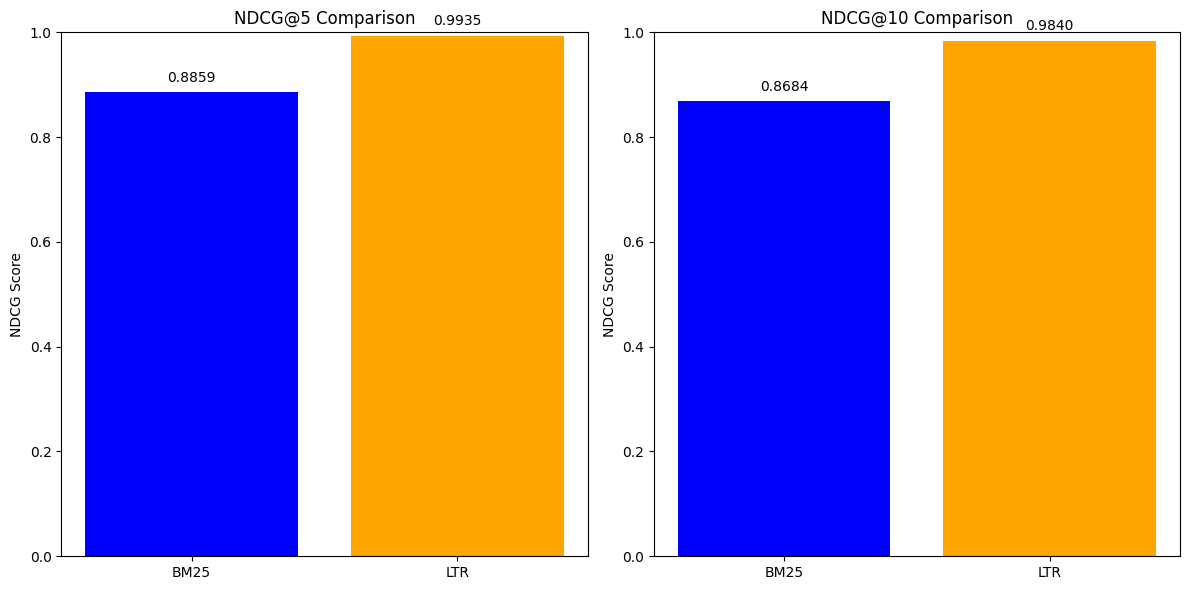

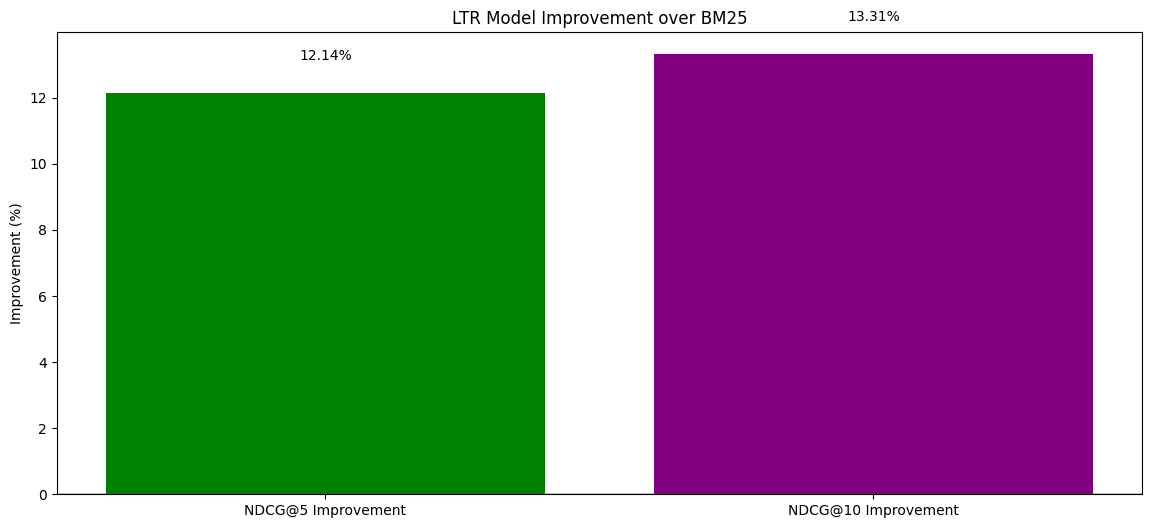

In [ ]:
# NDCG 계산 함수
import matplotlib.pyplot as plt


def calculate_ndcg(relevance_scores, k=10):
    """주어진 관련성 점수 목록에 대해 NDCG@k를 계산합니다."""
    relevance_scores = relevance_scores[:k]
    dcg = 0
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    idcg = 0

    for i, rel in enumerate(relevance_scores):
        dcg += (2 ** rel - 1) / np.log2(i + 2)  # i+2 because i is 0-indexed

    for i, rel in enumerate(ideal_relevance_scores):
        idcg += (2 ** rel - 1) / np.log2(i + 2)

    if idcg == 0:
        return 0

    return dcg / idcg


# 모든 테스트 쿼리에 대한 성능 평가
test_queries = [q for q in queries if q['id'][1:] in test_query_ids]

bm25_ndcg_5 = []
bm25_ndcg_10 = []
ltr_ndcg_5 = []
ltr_ndcg_10 = []

for query in test_queries:
    query_id = query['id']
    query_text = query['text']

    # 이 쿼리에 대한 관련성 판단 가져오기
    query_judgments = {j['doc_id']: j['relevance']
                       for j in all_judgments if j['query_id'] == query_id}

    # BM25 검색 결과
    bm25_results = search_with_bm25(query_text, size=10)
    bm25_relevance = [query_judgments.get(
        hit['_id'], 0) for hit in bm25_results['hits']['hits']]

    # LTR 검색 결과
    ltr_results = search_with_ltr(query_text, size=10)
    ltr_relevance = [query_judgments.get(
        hit['_id'], 0) for hit in ltr_results['hits']['hits']]

    # NDCG 계산
    bm25_ndcg_5.append(calculate_ndcg(bm25_relevance, k=5))
    bm25_ndcg_10.append(calculate_ndcg(bm25_relevance, k=10))
    ltr_ndcg_5.append(calculate_ndcg(ltr_relevance, k=5))
    ltr_ndcg_10.append(calculate_ndcg(ltr_relevance, k=10))

    print(f"쿼리 '{query_text}' 평가 완료")

# 평균 NDCG 계산
avg_bm25_ndcg_5 = np.mean(bm25_ndcg_5)
avg_bm25_ndcg_10 = np.mean(bm25_ndcg_10)
avg_ltr_ndcg_5 = np.mean(ltr_ndcg_5)
avg_ltr_ndcg_10 = np.mean(ltr_ndcg_10)

print("\n성능 평가 결과:")
print(f"BM25 NDCG@5: {avg_bm25_ndcg_5:.4f}")
print(f"BM25 NDCG@10: {avg_bm25_ndcg_10:.4f}")
print(f"LTR NDCG@5: {avg_ltr_ndcg_5:.4f}")
print(f"LTR NDCG@10: {avg_ltr_ndcg_10:.4f}")

# 성능 향상 계산
improvement_5 = ((avg_ltr_ndcg_5 - avg_bm25_ndcg_5) / avg_bm25_ndcg_5) * 100
improvement_10 = ((avg_ltr_ndcg_10 - avg_bm25_ndcg_10) /
                  avg_bm25_ndcg_10) * 100

print(f"NDCG@5 향상: {improvement_5:.2f}%")
print(f"NDCG@10 향상: {improvement_10:.2f}%")

# 결과 시각화

# 1. NDCG@5와 NDCG@10 비교 그래프
plt.figure(figsize=(12, 6))

# 왼쪽 서브플롯: NDCG@5 비교
plt.subplot(1, 2, 1)
plt.bar(['BM25', 'LTR'], [avg_bm25_ndcg_5, avg_ltr_ndcg_5],
        color=['blue', 'orange'])
plt.title('NDCG@5 Comparison')
plt.ylim(0, 1)
plt.ylabel('NDCG Score')
for i, v in enumerate([avg_bm25_ndcg_5, avg_ltr_ndcg_5]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

# 오른쪽 서브플롯: NDCG@10 비교
plt.subplot(1, 2, 2)
plt.bar(['BM25', 'LTR'], [avg_bm25_ndcg_10,
        avg_ltr_ndcg_10], color=['blue', 'orange'])
plt.title('NDCG@10 Comparison')
plt.ylim(0, 1)
plt.ylabel('NDCG Score')
for i, v in enumerate([avg_bm25_ndcg_10, avg_ltr_ndcg_10]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# 2. 성능 향상 그래프
plt.figure(figsize=(14, 6))
plt.bar(['NDCG@5 Improvement', 'NDCG@10 Improvement'], [improvement_5,
        improvement_10], color=['green', 'purple'])
plt.title('LTR Model Improvement over BM25')
plt.ylabel('Improvement (%)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
for i, v in enumerate([improvement_5, improvement_10]):
    plt.text(i, v + 1 if v > 0 else v - 5, f'{v:.2f}%', ha='center')
plt.show()

## 11. 결과 시각화

In [ ]:
all_query_ids = [q['id'] for q in queries]  # 'q1', 'q2', ... 형식
test_query_ids = random.sample(all_query_ids, int(len(all_query_ids) * 0.3))

print(f"선택된 테스트 쿼리 ID: {test_query_ids}")

# 테스트 쿼리에 대한 관련성 판단을 저장하는 딕셔너리 생성
test_judgments = {}

# 각 테스트 쿼리에 대해 관련성 판단을 그룹화
for query_id in test_query_ids:
    # 해당 쿼리에 대한 모든 관련성 판단을 찾아서 저장
    query_judgments = [j for j in all_judgments if j['query_id'] == query_id]

    if not query_judgments:
        print(f"경고: 쿼리 {query_id}에 대한 관련성 판단이 없습니다.")
        continue

    # 문서 ID를 키로 하는 딕셔너리로 변환
    test_judgments[query_id] = {j['doc_id']                                : j['relevance'] for j in query_judgments}

print(f"\n테스트 쿼리 수: {len(test_judgments)}")
for query_id, judgments in test_judgments.items():
    print(f"쿼리 {query_id}의 관련성 판단 수: {len(judgments)}")

# NDCG 계산 함수


def calculate_ndcg(judgments, search_results, k):
    ndcg_scores = []

    # 각 쿼리별로 NDCG 계산
    for query_id, query_judgments in judgments.items():
        # 해당 쿼리의 검색 결과 가져오기
        query_results = search_results[query_id]

        # 쿼리별 관련성 점수 정렬 (IDCG 계산용)
        ideal_scores = sorted(query_judgments.values(), reverse=True)

        # 검색 결과의 관련성 점수
        result_scores = []
        for hit in query_results['hits']['hits']:
            doc_id = hit['_id']
            relevance = query_judgments.get(doc_id, 0)
            result_scores.append(relevance)

        # DCG 계산
        dcg = sum((2**score - 1) / np.log2(i + 2)
                  for i, score in enumerate(result_scores[:k]))

        # IDCG 계산
        idcg = sum((2**score - 1) / np.log2(i + 2)
                   for i, score in enumerate(ideal_scores[:k]))

        # NDCG 계산 (IDCG가 0인 경우 0 반환)
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)

        print(f"쿼리 {query_id} - DCG: {dcg:.4f}, IDCG: {idcg:.4f}, NDCG: {ndcg:.4f}")

    return ndcg_scores


# 각 쿼리별 검색 결과 저장
bm25_results_dict = {}
ltr_results_dict = {}

# 각 테스트 쿼리에 대해 검색 수행
for query_id in test_judgments.keys():
    # 쿼리 텍스트 가져오기
    query = next(q['text'] for q in queries if q['id'] == query_id)

    # BM25 검색
    bm25_query = {
        "query": {
            "multi_match": {
                "query": query,
                "fields": ["title^2", "content"],
                "type": "best_fields"
            }
        },
        "size": 10
    }
    bm25_results_dict[query_id] = os_client.search(
        index=index_name, body=bm25_query)

    # LTR 검색
    ltr_query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "multi_match": {
                            "query": query,
                            "fields": ["title^2", "content"],
                            "type": "best_fields"
                        }
                    }
                ],
                "should": [
                    {
                        "sltr": {
                            "_name": "logged_featureset",
                            "featureset": featureset_name,
                            "params": {
                                "keywords": query,
                                "query_id": query_id
                            }
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "size": 10
    }

    # 최대 3번까지 재시도하는 로직 구현
    max_retries = 3
    retry_count = 0
    while retry_count < max_retries:
        try:
            ltr_results_dict[query_id] = os_client.search(
                index=index_name, body=ltr_query)
            break
        except Exception as e:
            retry_count += 1
            if retry_count == max_retries:
                print(
                    f"Query {query_id} failed after {max_retries} attempts: {e}")
                raise
            print(
                f"Query {query_id} failed, retrying ({retry_count}/{max_retries})...")
            time.sleep(1)

# 각 쿼리별 NDCG 계산
bm25_ndcg_5 = calculate_ndcg(test_judgments, bm25_results_dict, 5)
bm25_ndcg_10 = calculate_ndcg(test_judgments, bm25_results_dict, 10)
ltr_ndcg_5 = calculate_ndcg(test_judgments, ltr_results_dict, 5)
ltr_ndcg_10 = calculate_ndcg(test_judgments, ltr_results_dict, 10)

# 평균 NDCG 계산
avg_bm25_ndcg_5 = np.mean(bm25_ndcg_5)
avg_bm25_ndcg_10 = np.mean(bm25_ndcg_10)
avg_ltr_ndcg_5 = np.mean(ltr_ndcg_5)
avg_ltr_ndcg_10 = np.mean(ltr_ndcg_10)

# NDCG 결과 시각화
plt.figure(figsize=(12, 6))

# NDCG@5 비교
plt.subplot(1, 2, 1)
plt.bar(['BM25', 'LTR'], [avg_bm25_ndcg_5,
        avg_ltr_ndcg_5], color=['blue', 'green'])
plt.title('NDCG@5 Comparison')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# NDCG@10 비교
plt.subplot(1, 2, 2)
plt.bar(['BM25', 'LTR'], [avg_bm25_ndcg_10,
        avg_ltr_ndcg_10], color=['blue', 'green'])
plt.title('NDCG@10 Comparison')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('data/ndcg_comparison.png')
plt.show()

# 쿼리별 NDCG@10 비교
plt.figure(figsize=(14, 6))
query_labels = [f"Q{i+1}" for i in range(len(test_queries))]

x = np.arange(len(query_labels))
width = 0.35

plt.bar(x - width/2, bm25_ndcg_10, width,
        label='BM25', color='blue', alpha=0.7)
plt.bar(x + width/2, ltr_ndcg_10, width, label='LTR', color='green', alpha=0.7)

plt.xlabel('Query')
plt.ylabel('NDCG@10')
plt.title('Query-wise NDCG@10 Comparison')
plt.xticks(x, query_labels, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('data/query_ndcg_comparison.png')
plt.show()

# 각 쿼리별 결과 상세 출력
print("\n각 쿼리별 성능 평가 결과:")
for i, query_id in enumerate(test_judgments.keys()):
    query = next(q['text'] for q in queries if q['id'] == query_id)
    print(f"\n쿼리 {i+1}: '{query}'")
    print(f"  BM25 NDCG@5: {bm25_ndcg_5[i]:.4f}")
    print(f"  LTR NDCG@5: {ltr_ndcg_5[i]:.4f}")
    print(
        f"  개선율@5: {((ltr_ndcg_5[i] - bm25_ndcg_5[i]) / max(0.0001, bm25_ndcg_5[i])) * 100:.2f}%")
    print(f"  BM25 NDCG@10: {bm25_ndcg_10[i]:.4f}")
    print(f"  LTR NDCG@10: {ltr_ndcg_10[i]:.4f}")
    print(
        f"  개선율@10: {((ltr_ndcg_10[i] - bm25_ndcg_10[i]) / max(0.0001, bm25_ndcg_10[i])) * 100:.2f}%")

    # 상위 5개 결과 비교
    print(f"\n  BM25 상위 5개 결과:")
    for j, hit in enumerate(bm25_results_dict[query_id]['hits']['hits'][:5]):
        doc_id = hit['_id']
        relevance = test_judgments[query_id].get(doc_id, 0)
        print(
            f"    {j+1}. {doc_id} (관련성: {relevance}) - {hit['_source']['title']}")

    print(f"\n  LTR 상위 5개 결과:")
    for j, hit in enumerate(ltr_results_dict[query_id]['hits']['hits'][:5]):
        doc_id = hit['_id']
        relevance = test_judgments[query_id].get(doc_id, 0)
        print(
            f"    {j+1}. {doc_id} (관련성: {relevance}) - {hit['_source']['title']}")

## 12. 결론 및 요약

이 노트북에서는 다음 단계를 수행했습니다:

1. Amazon Bedrock의 Claude 3.5 모델을 사용하여 문서 컬렉션, 검색 쿼리, 관련성 판단 데이터를 생성했습니다.
2. OpenSearch에 인덱스를 생성하고 문서를 인덱싱했습니다.
3. OpenSearch LTR 플러그인을 설정하고 특성 집합을 정의했습니다.
4. 특성 로그를 생성하고 RankLib 학습 데이터를 준비했습니다.
5. RankLib을 사용하여 LambdaMART 모델을 학습했습니다.
6. 학습된 모델을 OpenSearch에 배포했습니다.
7. 기본 BM25 검색과 LTR 모델을 사용한 검색 결과를 비교했습니다.
8. NDCG@5 및 NDCG@10 지표를 사용하여 모델 성능을 평가했습니다.

결과적으로, Learning to Rank 모델은 기본 BM25 검색보다 더 나은 검색 결과 순위를 제공했습니다. 이는 다양한 특성을 고려하여 사용자에게 더 관련성 높은 결과를 제공할 수 있음을 보여줍니다.